In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import datetime
import warnings
warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error
import surprise as sp
from surprise.model_selection import cross_validate
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

2023-01-20 09:33:13.944426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 09:33:14.388131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2023-01-20 09:33:14.388147: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 09:33:15.524883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: can

In [2]:
# Load data

path = 'data/'
credits = pd.read_csv(path + 'credits.csv')
keywords = pd.read_csv(path + 'keywords.csv')
links_small = pd.read_csv(path + 'links_small.csv')
ratings = pd.read_csv(path + 'ratings.csv')
ratings_small = pd.read_csv(path + 'ratings_small.csv')
md = pd.read_csv(path + 'movies_metadata.csv').drop([19730, 29503, 35587])

In [3]:
# Drop unnecessary columns

md = md.drop(['adult', 'homepage', 'imdb_id', 'spoken_languages', 
              'original_title', 'video', 'poster_path', 'popularity'], axis=1)

print(list(md))

['belongs_to_collection', 'budget', 'genres', 'id', 'original_language', 'overview', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title', 'vote_average', 'vote_count']


In [4]:
# Merge metadata with credits and keywords

md['id'] = md['id'].astype('int')
credits['id'] = credits['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')

md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [5]:
# Retrieve only names from columns with lists and dictionaries

def get_names(x):
    if isinstance(x, list):
        return [i['name'] for i in x]  
    elif isinstance(x, dict):
        return x['name']
    else:
        return []

lists = ['belongs_to_collection', 'genres', 'production_companies', 
         'production_countries', 'cast', 'keywords']

for l in lists:
  md[l] = md[l].fillna('[]').apply(literal_eval).apply(get_names)

md['belongs_to_collection'] = md['belongs_to_collection'].apply(lambda x: np.nan if len(x) == 0 else x)

In [6]:
# Create 'director' column from 'crew'

def get_director(x):
  for i in x:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

md['director'] = md['crew'].apply(literal_eval).apply(get_director)

In [7]:
# Clean 'revenue' and 'budget' columns
# Create 'profit' and 'return' columns

md['revenue'] = md['revenue'].replace(0, np.nan)
md['budget'] = pd.to_numeric(md['budget'], errors='coerce').replace(0, np.nan)
md['profit'] = md['revenue'] - md['budget']
md['return'] = md['revenue'] / md['budget']

In [8]:
# Clean 'vote_count' and 'vote_average' columns

def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan
    
md['vote_count'] = md['vote_count'].apply(clean_numeric).astype('float')
md['vote_average'] = md['vote_average'].apply(clean_numeric).astype('float').replace(0, np.nan)

In [9]:
# Create 'year', 'month' and 'day' columns from 'release_date'

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def get_year(x):
    try:
        return int(str(x).split('-')[0])
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan
                   
md['year'] = md['release_date'].apply(get_year).replace('NaT', np.nan).apply(clean_numeric)
md['month'] = md['release_date'].apply(get_month)
md['day'] = md['release_date'].apply(get_day)

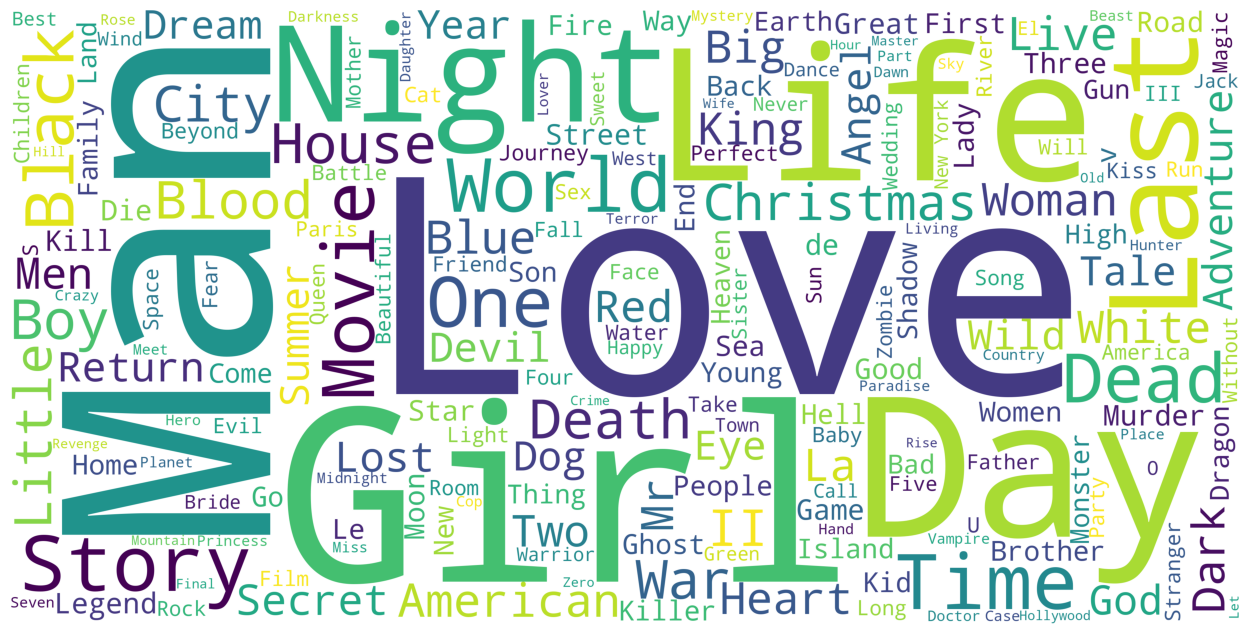

In [10]:
# Wordcloud from 'title'

def generate_wordcloud(corpus):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(corpus)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
md['title'] = md['title'].astype('str')
title_corpus = ' '.join(md['title'])
generate_wordcloud(title_corpus)

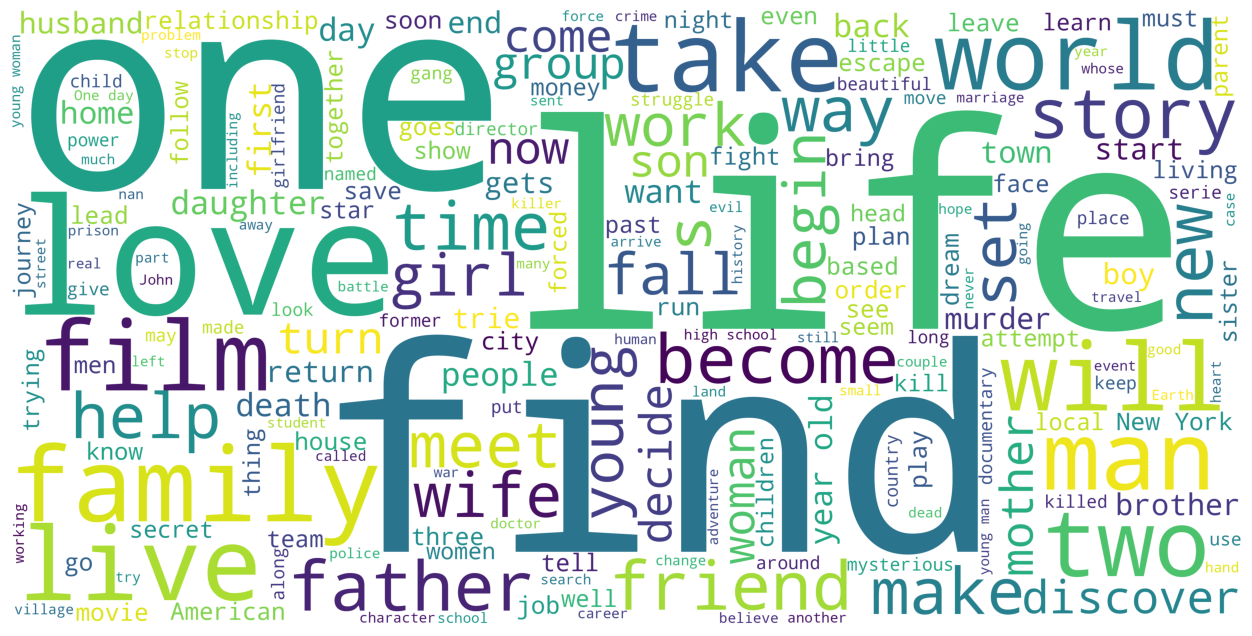

In [11]:
# Wordcloud from 'overview'

md['overview'] = md['overview'].astype('str')
overview_corpus = ' '.join(md['overview'])
generate_wordcloud(overview_corpus)

In [12]:
franchises = md.pivot_table(index='belongs_to_collection', values='revenue', 
                                  aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [13]:
# Highest grossing movie franchises

franchises.sort_values('sum', ascending=False).head(10)

belongs_to_collection  count          mean           sum
552               Harry Potter Collection      8  9.634209e+08  7.707367e+09
1160                 Star Wars Collection      8  9.293118e+08  7.434495e+09
646                 James Bond Collection     26  2.733450e+08  7.106970e+09
1317  The Fast and the Furious Collection      8  6.406373e+08  5.125099e+09
968   Pirates of the Caribbean Collection      5  9.043154e+08  4.521577e+09
1550              Transformers Collection      5  8.732202e+08  4.366101e+09
325              Despicable Me Collection      4  9.227676e+08  3.691070e+09
1491              The Twilight Collection      5  6.684215e+08  3.342107e+09
610                    Ice Age Collection      5  6.433417e+08  3.216709e+09
666              Jurassic Park Collection      4  7.578710e+08  3.031484e+09

In [14]:
# Unexpected successes (high return ratio)

md[md['budget'] > 5e6][['title', 'year', 'return']].sort_values('return', ascending=False).head(10)

title    year     return
1086    E.T. the Extra-Terrestrial  1982.0  75.520507
256                      Star Wars  1977.0  70.490728
1359                          Jaws  1975.0  67.236286
1908                  The Exorcist  1973.0  55.163268
352    Four Weddings and a Funeral  1994.0  42.450139
841                  The Godfather  1972.0  40.844402
4533            Look Who's Talking  1989.0  39.466667
24460                    Annabelle  2014.0  39.272894
1077                 Dirty Dancing  1987.0  35.659046
1027            The Sound of Music  1965.0  34.904181

In [15]:
# Unexpected disasters (low return ratio)

md[(md['budget'] > 5e6) & (md['revenue'] > 1e4)][['title', 'year', 'return']].sort_values('return', ascending=True).head(10)

title    year    return
11261                Chaos  2005.0  0.000514
19217        5 Days of War  2011.0  0.000874
21235       Special Forces  2011.0  0.001076
25933           Foodfight!  2012.0  0.001134
39557            Term Life  2016.0  0.001288
19695     Laurence Anyways  2012.0  0.001289
12147       The Good Night  2007.0  0.001359
3993           Cherry 2000  1987.0  0.001400
22295           Twice Born  2012.0  0.001407
5706   All The Queen's Men  2001.0  0.001533

In [16]:
# Movies with highest profit

md[['title', 'year', 'profit']].sort_values('profit', ascending=False).head(10)

title    year        profit
14723                                        Avatar  2009.0  2.550965e+09
26770                  Star Wars: The Force Awakens  2015.0  1.823224e+09
1659                                        Titanic  1997.0  1.645034e+09
25285                                Jurassic World  2015.0  1.363529e+09
29044                                     Furious 7  2015.0  1.316249e+09
18008                                  The Avengers  2012.0  1.299558e+09
17627  Harry Potter and the Deathly Hallows: Part 2  2011.0  1.217000e+09
26773                       Avengers: Age of Ultron  2015.0  1.125404e+09
22308                                        Frozen  2013.0  1.124219e+09
43388                          Beauty and the Beast  2017.0  1.102886e+09

In [17]:
# Movies with highest number of votes

md[['title', 'year', 'vote_count']].sort_values('vote_count', ascending=False).head(10)

title    year  vote_count
15651                Inception  2010.0     14075.0
12589          The Dark Knight  2008.0     12269.0
14723                   Avatar  2009.0     12114.0
18008             The Avengers  2012.0     12000.0
26779                 Deadpool  2016.0     11444.0
23076             Interstellar  2014.0     11187.0
20254         Django Unchained  2012.0     10297.0
23948  Guardians of the Galaxy  2014.0     10014.0
2870                Fight Club  1999.0      9678.0
18434         The Hunger Games  2012.0      9634.0

In [18]:
# Movies with more than 2k votes and best average vote

md[md['vote_count'] > 2000][['title', 'year', 'vote_average', 'vote_count']].sort_values(['vote_average', 'vote_count'], ascending=False).head(10)

title    year  vote_average  vote_count
314    The Shawshank Redemption  1994.0           8.5      8358.0
841               The Godfather  1972.0           8.5      6024.0
12589           The Dark Knight  2008.0           8.3     12269.0
2870                 Fight Club  1999.0           8.3      9678.0
292                Pulp Fiction  1994.0           8.3      8670.0
522            Schindler's List  1993.0           8.3      4436.0
23868                  Whiplash  2014.0           8.3      4376.0
5529              Spirited Away  2001.0           8.3      3968.0
2231          Life Is Beautiful  1997.0           8.3      3643.0
1199     The Godfather: Part II  1974.0           8.3      3418.0

<AxesSubplot:xlabel='vote_average', ylabel='Density'>

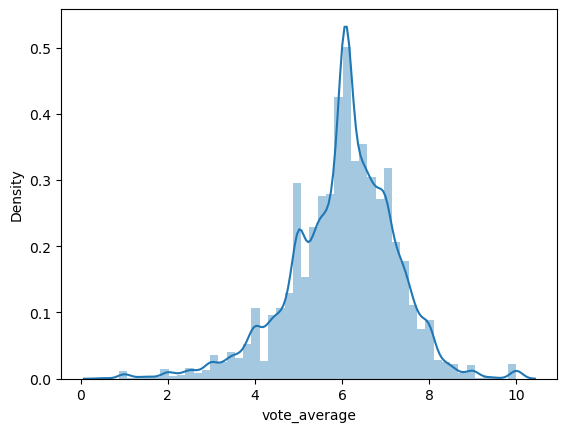

In [19]:
# Distribution of average vote between movies

sns.distplot(md['vote_average'].fillna(md['vote_average'].median()))

In [20]:
# Number of movies released in a particular year.

data = md['year'].value_counts().sort_index()

trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))

layout = dict(title = 'Number of movies released in a particular year',
              xaxis = dict(title = 'Release Date'),
              yaxis = dict(title = 'Movies'))


fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<AxesSubplot:title={'center':'Number of Movies released in a particular month.'}, xlabel='month', ylabel='count'>

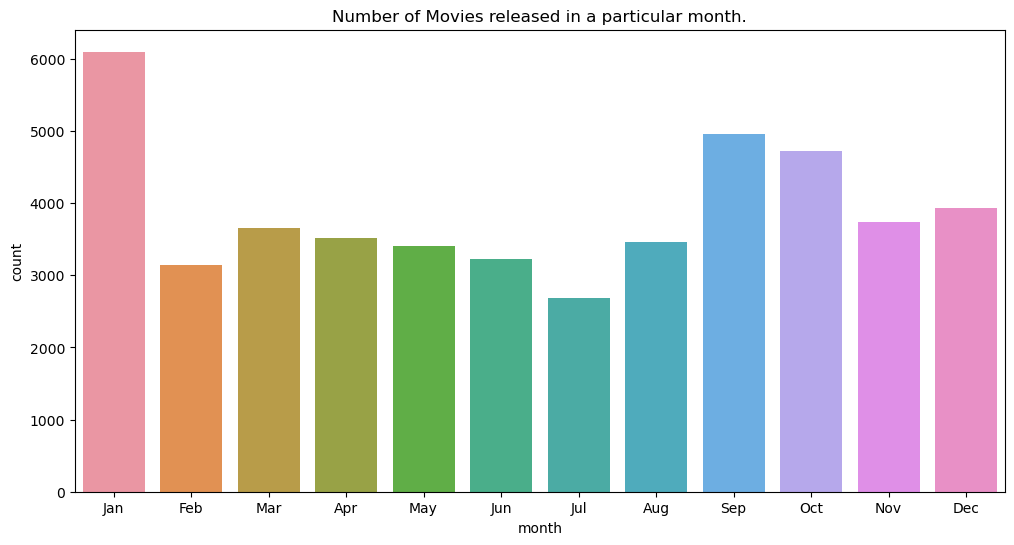

In [21]:
# Number of movies released in a particular month

plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=md, order=month_order)

<AxesSubplot:title={'center':'Average gross by the month for blockbuster movies (with budget > 100M $)'}, xlabel='mon', ylabel='revenue'>

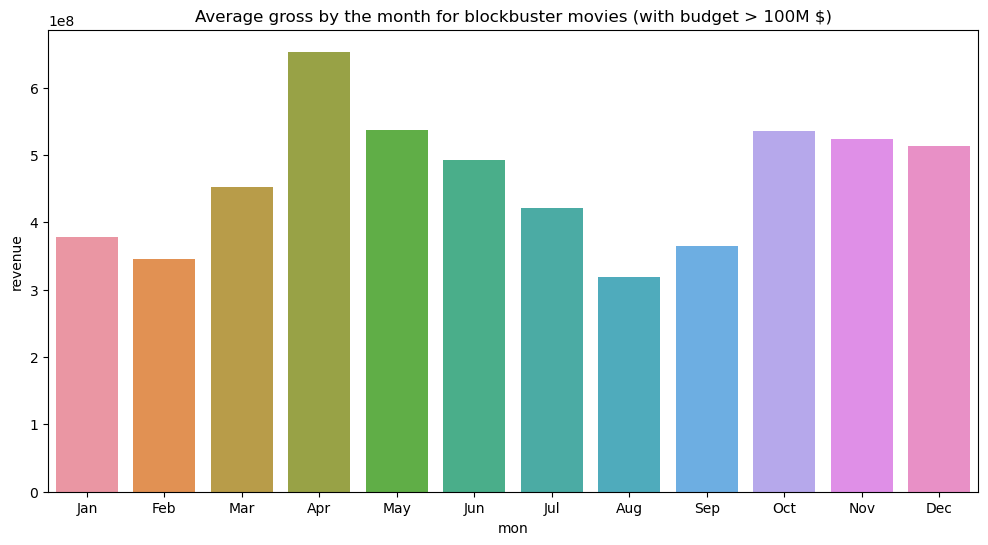

In [22]:
# Average gross by the month for blockbuster movies (with budget > 100M $)

month_mean = pd.DataFrame(md[md['budget'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average gross by the month for blockbuster movies (with budget > 100M $)")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

<AxesSubplot:title={'center':'Average gross by the month for low-budget movies (with budget < 10M $)'}, xlabel='mon', ylabel='revenue'>

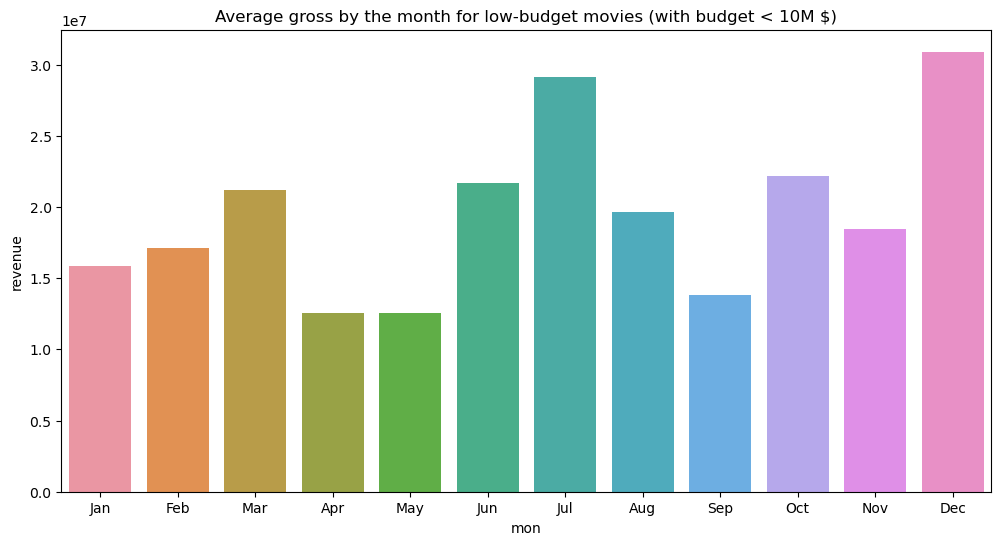

In [23]:
# Average gross by the month for low-budget movies (with budget < 10M $)

month_mean = pd.DataFrame(md[md['budget'] < 1e7].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average gross by the month for low-budget movies (with budget < 10M $)")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

<AxesSubplot:title={'center':'Number of movies released on a particular day'}, xlabel='day', ylabel='count'>

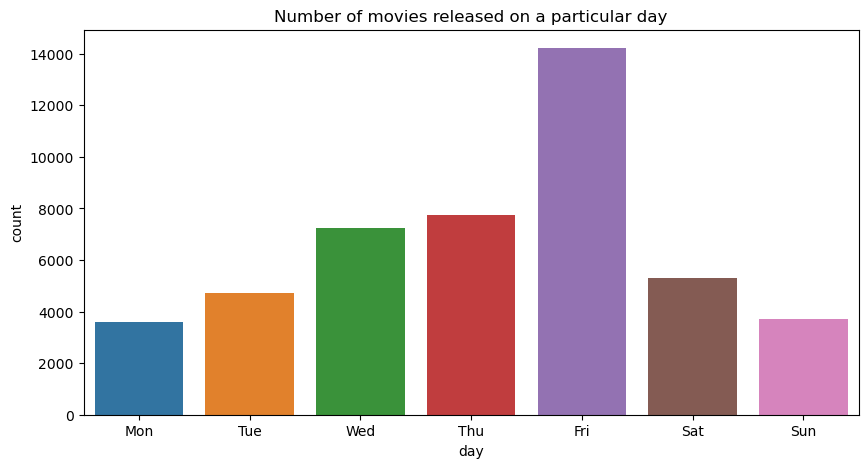

In [24]:
# Number of movies released on a particular day

plt.figure(figsize=(10,5))
plt.title("Number of movies released on a particular day")
sns.countplot(x='day', data=md, order=day_order)

<AxesSubplot:xlabel='runtime', ylabel='Density'>

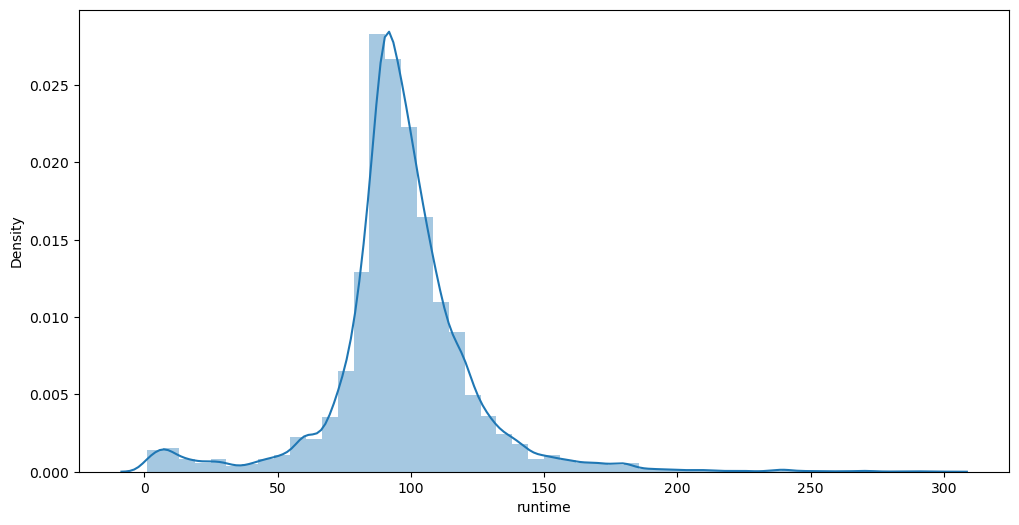

In [25]:
# Distribution of runtime between movies

plt.figure(figsize=(12,6))
sns.distplot(md[(md['runtime'] < 300) & (md['runtime'] > 0)]['runtime'])

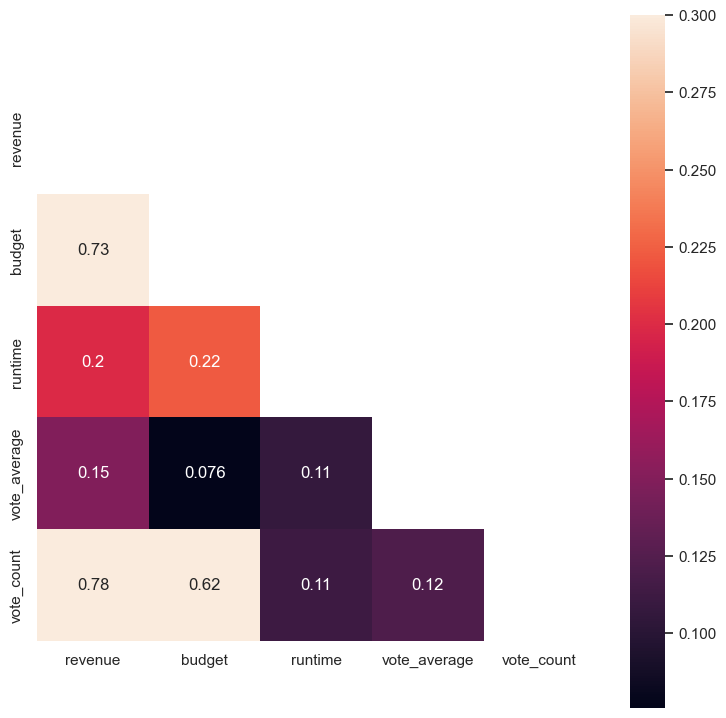

In [26]:
# Correlations between some features

sns.set(font_scale=1)
corr = md[['revenue', 'budget', 'runtime', 'vote_average', 'vote_count']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [27]:
# Genres counts

genres = pd.DataFrame(md['genres'].explode().value_counts().reset_index())
genres.columns = ['genre', 'movies']
genres

genre  movies
0             Drama   20809
1            Comedy   13467
2          Thriller    7794
3           Romance    6923
4            Action    6730
5            Horror    4762
6             Crime    4387
7       Documentary    4050
8         Adventure    3587
9   Science Fiction    3140
10           Family    2831
11          Mystery    2541
12          Fantasy    2385
13        Animation    1998
14          Foreign    1681
15            Music    1630
16          History    1427
17              War    1348
18          Western    1059
19         TV Movie     793

In [28]:
# Genres that we will consider

genres_list = list(genres['genre'][:14])
genres_list.remove('Documentary')
print(genres_list)

# Movies of genres that we consider
exp = md.explode('genres').rename(columns={'genres': 'genre'})
pop_gen_movies = exp[(exp['genre'].isin(genres_list))]

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation']


<Figure size 1800x800 with 0 Axes>

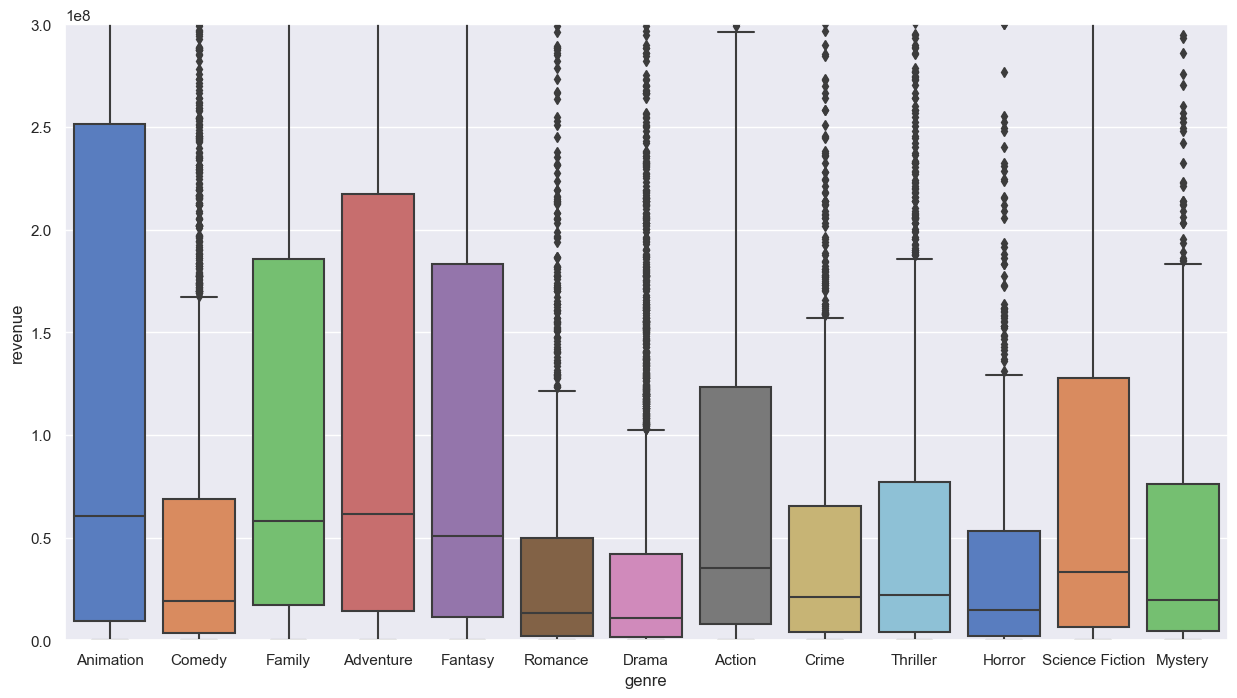

In [29]:
# Revenue distribution by genre

def boxplot_genres(feature, limits, df=pop_gen_movies):
    plt.figure(figsize=(18,8))
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
    sns.boxplot(x='genre', y=feature, data=df, palette="muted", ax=ax)
    ax.set_ylim(limits)
    plt.show()
    
boxplot_genres('revenue', [0, 3e8])

<Figure size 1800x800 with 0 Axes>

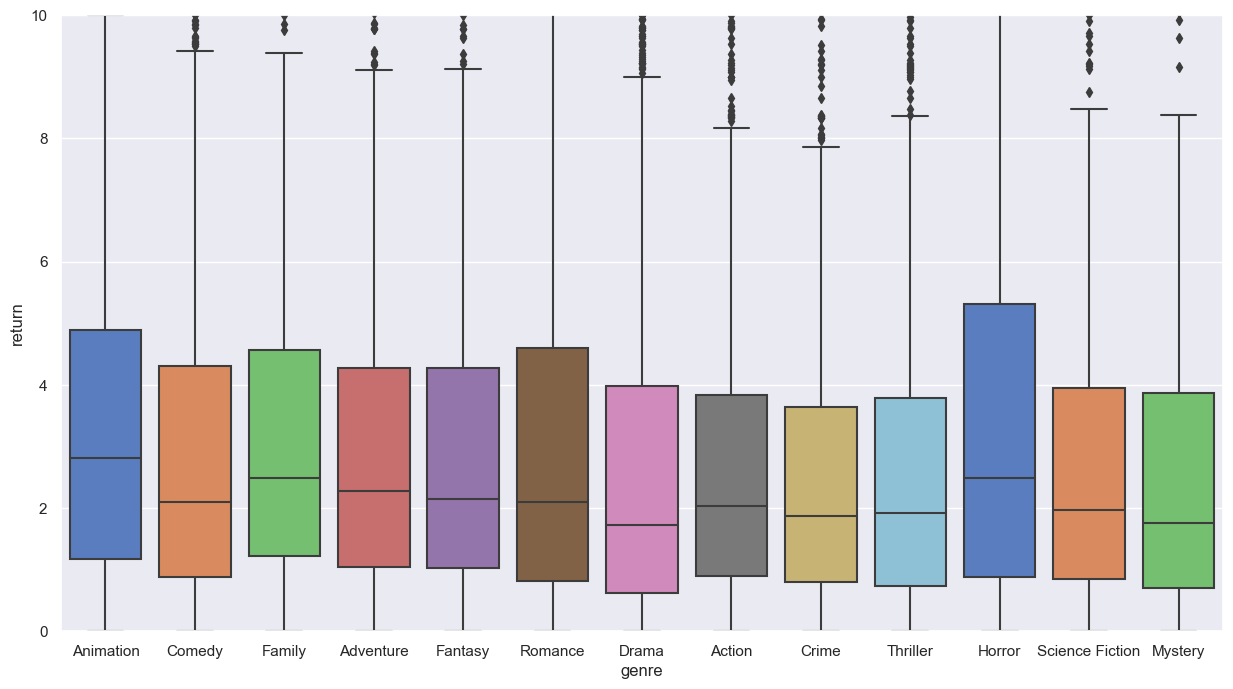

In [30]:
# Return ratio distribution by genre

boxplot_genres('return', [0, 10])

<Figure size 1800x800 with 0 Axes>

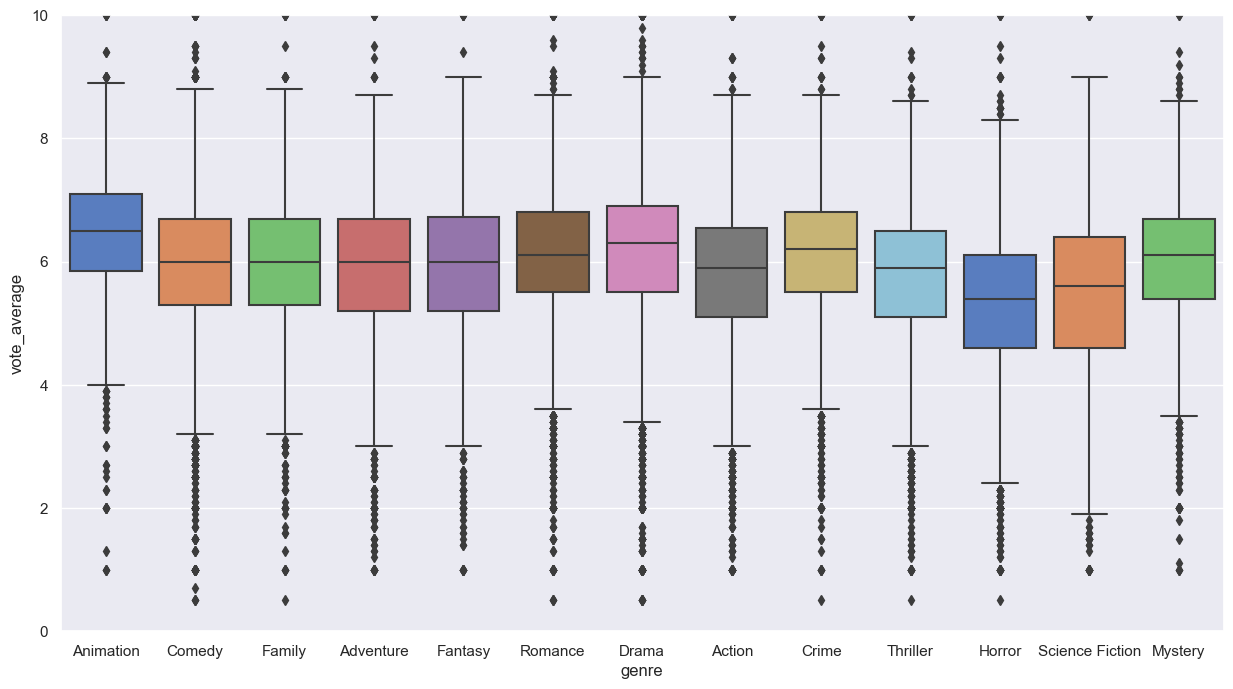

In [31]:
# Average vote distribution by genre

boxplot_genres('vote_average', [0, 10])

<Figure size 1800x800 with 0 Axes>

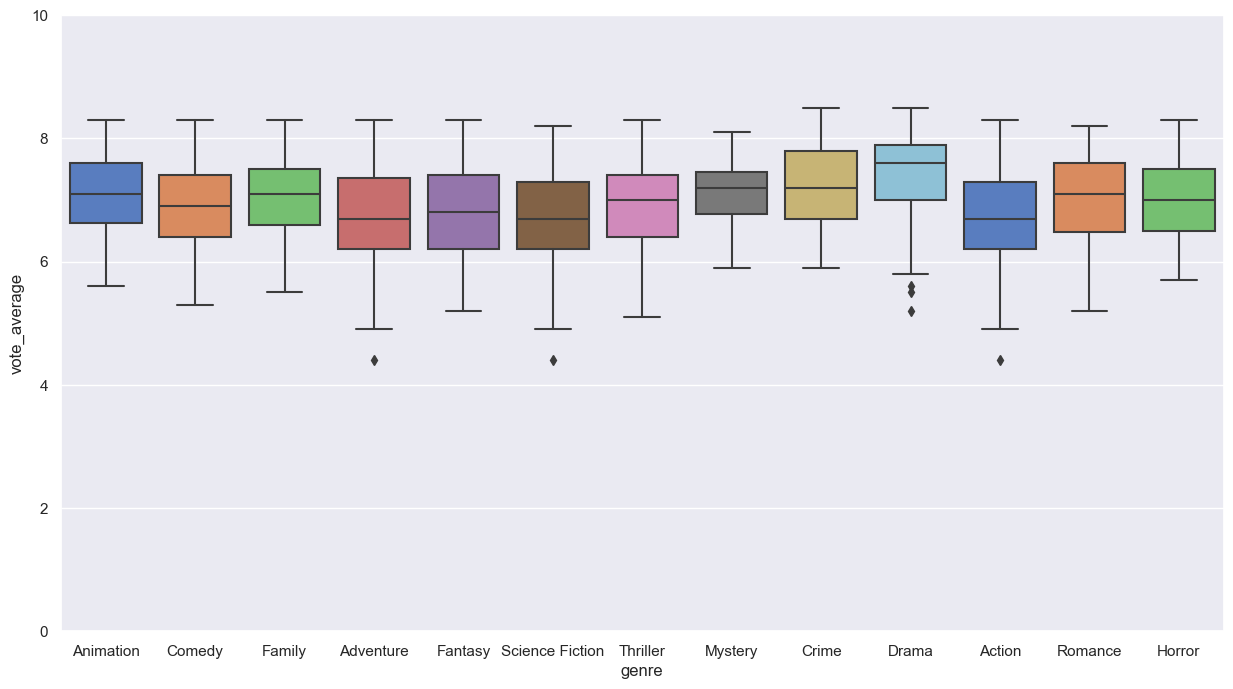

In [32]:
# Average vote distribution by genre for movies that have many votes

boxplot_genres('vote_average', [0, 10], pop_gen_movies[pop_gen_movies['vote_count'] > 2000])

<Figure size 1800x800 with 0 Axes>

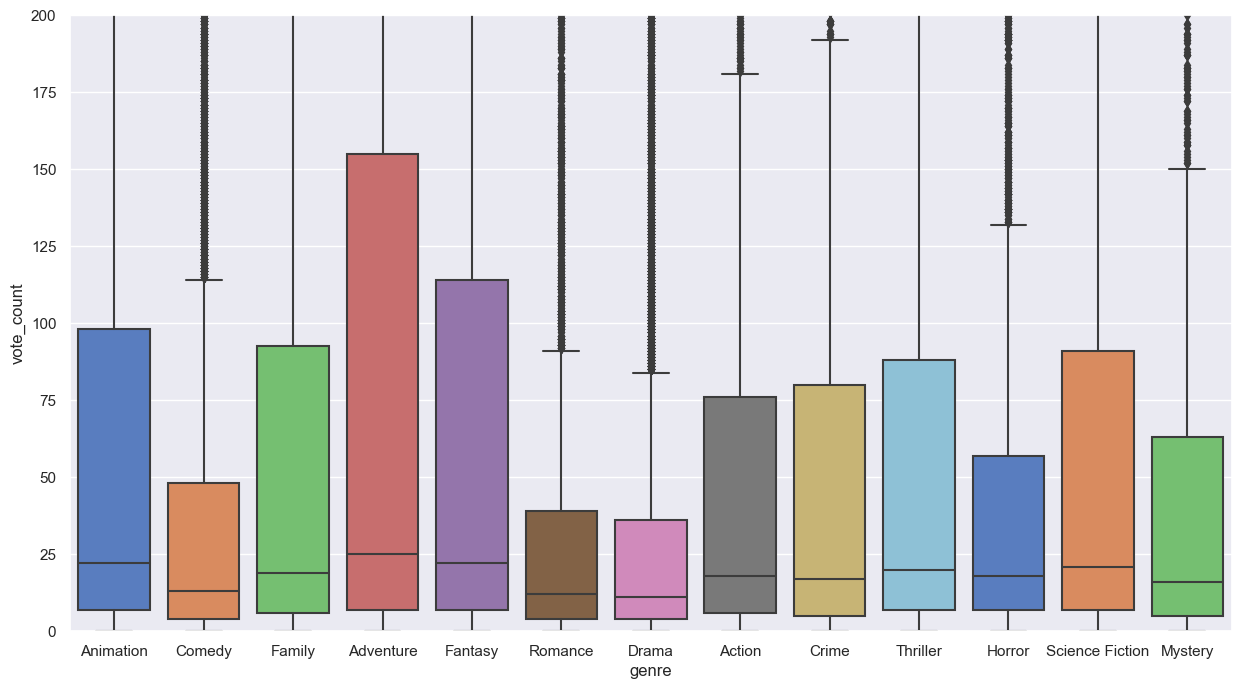

In [33]:
# Vote count distribution by genre

boxplot_genres('vote_count', [0, 200])

In [34]:
# Prepare data for Content Based Recommender System

def clean_strings(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(' ', ''))
    else:
        return np.nan


links_small['tmdbId'] = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
cbrs = md[md['id'].isin(links_small['tmdbId'])].sort_values('vote_count', ascending=False).drop_duplicates(subset=['title']).reset_index()

for feature in ['director', 'cast', 'genres', 'keywords']:
    cbrs[feature] = cbrs[feature].apply(clean_strings)

cbrs['cast'] = cbrs['cast'].apply(lambda x: x[:3])
cbrs['keywords'] = cbrs['keywords'].apply(lambda x: x[:5])
cbrs['director'] = cbrs['director'].fillna('')

In [35]:
def mix_features(x):
    genres = ' '.join(x['genres'])
    keywords = ' ' + ' '.join(x['keywords'])
    director = ' ' + x['director']
    actors = ' ' + ' '.join(x['cast'])
    return genres + keywords + director + actors

cbrs['features'] = cbrs.apply(mix_features, axis=1)

In [36]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(cbrs['features'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(cbrs.index, index=cbrs['title'])

In [37]:
def get_recommendations(title, n=10, sim=cosine_sim):
    # Get the index of the movie that matches the title
    if title not in indices:
        return 'Sorry, the movie "' + title + '" does not exist in our database.'
    idx = indices[title]

    print(f'Movies similar to "{title}":')
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = pd.Series(enumerate(sim[idx]))
    
    # Take only movies with significant popularity
    sim_scores = sim_scores[cbrs['vote_count'] > 1000]

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the n most similar movies
    sim_scores = sim_scores[1:n+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    titles = cbrs['title'].iloc[movie_indices].reset_index(drop=True)
    titles.index += 1
    return titles

In [38]:
get_recommendations('The Lion King')

Movies similar to "The Lion King":


1                         Inside Out
2                              Bambi
3     The Lion King 2: Simba's Pride
4        The Hunchback of Notre Dame
5                Monsters University
6                             Tarzan
7                         Pocahontas
8                        Toy Story 3
9                          Space Jam
10                                Up
Name: title, dtype: object

In [39]:
get_recommendations('Interstellar')

Movies similar to "Interstellar":


1                      The Martian
2                          Contact
3               Terminator Genisys
4     A.I. Artificial Intelligence
5              The Matrix Reloaded
6           The Matrix Revolutions
7                       About Time
8                       Ex Machina
9                             Moon
10                The Tree of Life
Name: title, dtype: object

In [40]:
get_recommendations('The Shining')

Movies similar to "The Shining":


1                         1408
2                       Psycho
3                    Insidious
4     The Purge: Election Year
5                   Red Dragon
6                The Conjuring
7                         Room
8       The Cabin in the Woods
9           The Purge: Anarchy
10                  It Follows
Name: title, dtype: object

In [41]:
# Get data
data = ratings['rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Distribution Of {} Ratings'.format(ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [42]:
# Get data
data = pd.to_datetime(ratings['timestamp'], unit='s').apply(lambda x: x.date()).value_counts()
data.sort_index(inplace=True)

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movie-Ratings Grouped By Day'.format(ratings.shape[0]),
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Ratings'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [43]:
##### Ratings Per Movie #####
# Get data
data = ratings.groupby('movieId')['rating'].count().clip(upper=9999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 100),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie (Clipped at 9999)',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)



##### Ratings Per User #####
# Get data
data = ratings.groupby('userId')['rating'].count().clip(upper=199)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 199)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [44]:
df = ratings

# Filter sparse movies
min_movie_ratings = 10000
filter_movies = (df['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(26024289, 4)
Shape User-Ratings filtered:	(6655935, 4)


In [45]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = df_filterd.shape[0]//10

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [46]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(index='userId', columns='movieId', values='rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.sample(3)

Shape User-Movie-Matrix:	(32811, 636)


movieId  1       2       3       5       6       7       10      11      \
userId                                                                    
147094      5.0     4.0     NaN     NaN     NaN     NaN     NaN     NaN   
152041      3.0     NaN     NaN     NaN     2.5     2.0     NaN     3.0   
39273       NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  16      17      ...  99114   106782  109487  112556  112852  116797  \
userId                   ...                                                   
147094      NaN     3.0  ...     NaN     4.0     4.0     NaN     NaN     5.0   
152041      3.0     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
39273       NaN     3.0  ...     NaN     2.5     NaN     3.0     NaN     NaN   

movieId  122882  122886  134130  134853  
userId                                   
147094      NaN     NaN     NaN     5.0  
152041      NaN     NaN     NaN     NaN  
39273       5.0     4.0     3.0     NaN  

[3 rows x 636 columns]

In [47]:
# Top n movies
n = 10

# Compute mean rating for all movies
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

# Count ratings for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Count').to_frame()

# Combine ratings_mean, ratings_count and movie_titles
ranking_mean_rating = ratings_mean.head(n).join(ratings_count).join(md[["id", "title"]])


# Join labels and predictions
df_prediction = df_test.set_index('movieId').join(ratings_mean)[['rating', 'Rating-Mean']]
y_true = df_prediction['rating']
y_pred = df_prediction['Rating-Mean']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))


# Create trace
trace = go.Bar(x = ranking_mean_rating['Rating-Mean'],
               text = ranking_mean_rating['title'].astype(str) +': '+ ranking_mean_rating['Rating-Count'].astype(str) + ' Ratings',
               textposition = 'outside',
               textfont = dict(color = '#000000'),
               orientation = 'h',
               y = list(range(1, n+1)),
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Ranking Of Top {} Mean-Movie-Ratings: {:.4f} RMSE'.format(n, rmse),
              xaxis = dict(title = 'Mean-Rating',
                          range = (4.1, 4.55)),
              yaxis = dict(title = 'Movie'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [48]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean()

# Mean rating for all movies separatly
R = df_p.mean(axis=0).values

# Rating count for all movies separatly
v = df_p.count().values


# Weighted formula to compute the weighted rating
weighted_score = (v/ (v+m) *R) + (m/ (v+m) *C)
# Sort ids to ranking
weighted_ranking = np.argsort(weighted_score)[::-1]
# Sort scores to ranking
weighted_score = np.sort(weighted_score)[::-1]
# Get movie ids
weighted_movie_ids = df_p.columns[weighted_ranking]


# Join labels and predictions
df_prediction = df_test.set_index('movieId').join(pd.DataFrame(weighted_score, index=weighted_movie_ids, columns=['Prediction']))[['rating', 'Prediction']]
y_true = df_prediction['rating']
y_pred = df_prediction['Prediction']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))


# Create DataFrame for plotting
df_plot = pd.DataFrame(weighted_score[:n], columns=['Rating'])
df_plot.index = weighted_movie_ids[:10]
ranking_weighted_rating = df_plot.join(ratings_count).join(md[["id", "title"]])
del df_plot


# Create trace
trace = go.Bar(x = ranking_weighted_rating['Rating'],
               text = ranking_weighted_rating['title'].astype(str) +': '+ ranking_weighted_rating['Rating-Count'].astype(str) + ' Ratings',
               textposition = 'outside',
               textfont = dict(color = '#000000'),
               orientation = 'h',
               y = list(range(1, n+1)),
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Ranking Of Top {} Weighted-Movie-Ratings: {:.4f} RMSE'.format(n, rmse),
              xaxis = dict(title = 'Weighted Rating',
                          range = (4.15, 4.6)),
              yaxis = dict(title = 'Movie'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [49]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['userId'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['movieId'].unique())}


# Create correctly mapped train- & testset
train_user_data = df_train['userId'].map(user_id_mapping)
train_movie_data = df_train['movieId'].map(movie_id_mapping)

test_user_data = df_test['userId'].map(user_id_mapping)
test_movie_data = df_test['movieId'].map(movie_id_mapping)


# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 10


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))

2023-01-20 09:34:48.074776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:34:48.074994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2023-01-20 09:34:48.075069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2023-01-20 09:34:48.075120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror:

20800/20800 [==============================] - 9s 441us/step


Testing Result With Keras Matrix-Factorization: 0.8637 RMSE


In [50]:
# Setup variables
user_embedding_size = 20
movie_embedding_size = 10


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))

20800/20800 [==============================] - 10s 462us/step


Testing Result With Keras Deep Learning: 0.8379 RMSE


In [51]:
# Load dataset into surprise specific data-structure
data = sp.Dataset.load_from_df(df_filterd[['userId', 'movieId', 'rating']].sample(20000), sp.Reader())

benchmark = []
# Iterate over all algorithms
for algorithm in [sp.SVD(), sp.SVDpp(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp, pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    
    # Store data
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [52]:
# Store results
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse', ascending=False)

# Get data
data = surprise_results[['test_rmse', 'test_mae']]
grid = data.values

# Create axis labels
x_axis = [label.split('_')[1].upper() for label in data.columns.tolist()]
y_axis = data.index.tolist()

x_label = 'Function'
y_label = 'Algorithm'


# Get annotations and hovertext
hovertexts = []
annotations = []
for i, y_value in enumerate(y_axis):
    row = []
    for j, x_value in enumerate(x_axis):
        annotation = grid[i, j]
        row.append('Error: {:.3f}<br>{}: {}<br>{}: {}<br>Fit Time: {:.3f}s<br>Test Time: {:.3f}s'.format(annotation, y_label, y_value ,x_label, x_value, surprise_results.loc[y_value]['fit_time'], surprise_results.loc[y_value]['test_time']))
        annotations.append(dict(x=x_value, y=y_value, text='{:.3f}'.format(annotation), ax=0, ay=0, font=dict(color='#000000')))
    hovertexts.append(row)

# Create trace
trace = go.Heatmap(x = x_axis,
                   y = y_axis,
                   z = data.values,
                   text = hovertexts,
                   hoverinfo = 'text',
                   colorscale = 'Picnic',
                   colorbar = dict(title = 'Error'))

# Create layout
layout = go.Layout(title = 'Crossvalidated Comparison Of Surprise Algorithms',
                   xaxis = dict(title = x_label),
                   yaxis = dict(title = y_label,
                                tickangle = -40),
                   annotations = annotations)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)